# The Leaf Classifier 🍃

This project builds a deep learning model to classify three types of tree leaves—Neem, Jujube, and Bougainvillea using a high-quality image dataset from Mendeley.

Leaf Species in the Dataset:
- **Neem:** Medicinal tree native to India, with pinnate leaves.
- **Jujube:** Small fruit-bearing tree, with shiny oval leaves.
- **Bougainvillea:** Flowering shrub or vine, with colorful bracts and green leaves.

A link to the dataset:  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bgmftbm8zt-1.zip

### Intended Outcomes

**Accurate Leaf Classification**
The model should correctly identify each leaf as Neem, Jujube and Bougainvillea, demonstrating the ability to distinguish visually similar classes.

**End-to-End Production Workflow**
Gain hands-on experience in exporting a trained model (learn.export()) and loading it for inference (load_learner()).

**Interactive Prediction Interface**
Build a simple Gradio app that allows users to upload an image and get real-time predictions, showcasing a deployable ML workflow.

**Understanding of Model Challenges**
Learn how subtle visual differences affect predictions, data preparation, and model performance.

## Data Preparation

PyTorch's Apple GPU backend (MPS) does not yet support all the operations FastAI uses.  Therefore the line below tells PyTorch that if an operation is not supported on the Apple GPU, run it on the CPU instead of crashing.

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


We have downloaded the dataset and stored them in a separate folder for each leaf type: Neem, Jujube and Bougainvillea.  Let's first ensure we can access the file path to the images and check the number of images.

In [2]:
from pathlib import Path
from fastai.vision.all import get_image_files

# Step 1: Set the base path to your dataset
base_path = Path('data/leaf')  # adjust if your folder name differs

# Step 2: Check if the folder exists
if not base_path.exists():
    print(f"ERROR: Folder {base_path} does not exist. Check the path!")
else:
    print(f"Folder {base_path} exists ✅")

    # Step 3: List subfolders (should be your classes)
    subfolders = [f for f in base_path.iterdir() if f.is_dir()]
    print("Found subfolders (classes):", [f.name for f in subfolders])

    # Step 4: Count images in each subfolder
    for folder in subfolders:
        images = get_image_files(folder)
        print(f"Class '{folder.name}': {len(images)} images")


/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <C62FA868-4C49-3B20-AFA6-2F7F59A295B4> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Folder data/leaf exists ✅
Found subfolders (classes): ['neem leaf', 'Bougainvillea leaf', 'Jujube']
Class 'neem leaf': 45 images
Class 'Bougainvillea leaf': 161 images
Class 'Jujube': 128 images


We can see that we have a class imbalance: 'neem' leaf has far fewer images in comparison to the classes Bougainvillea and Jujube respectively.

### Convert files from HEIC to JPG/PNG

The first issue we need to deal with is that the images in our data folders are HEIC files (.heic).  PIL/FastAI can't open HEIC files by default, therefore we need to convert them to JPG/PNG format.

In [3]:
# Install pillow-heif if needed
# pip install pillow-heif

import pillow_heif         # Import the pillow-heif library to read HEIC image files
from pathlib import Path   # Import Path from pathlib to handle file system paths easily
from PIL import Image      # Import PIL's Image module to create and save images

# Define the path to the dataset folder containing leaf images
path = Path('data/leaf')

# Loop through all files in the folder and subfolders that end with '.heic'
for img_path in path.rglob('*.heic'):
    # Read the HEIC file into a pillow-heif object
    heif_file = pillow_heif.read_heif(str(img_path))

    # Convert the HEIC data into a standard PIL image   
    img = Image.frombytes(
        heif_file.mode,     # Colour mode e.g. 'RGB'
        heif_file.size,     # Width and height of the image
        heif_file.data,     # Raw image bytes
        "raw"
    )
    # Create a new path for the converted image with a '.jpg' extension
    new_path = img_path.with_suffix('.jpg')

    # Save the image as a JPG file in the same folder
    img.save(new_path)

    # Delete the original HEIC file (optional_
    img_path.unlink() 


Let's randomly inspect an image from each class.

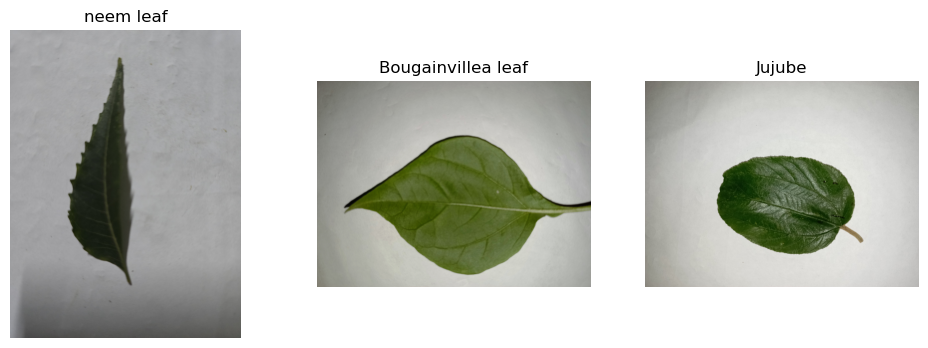

In [5]:
import random                           # Import the random module to pick random images
from fastai.vision.all import *         # Import FastAI vision utilities
from matplotlib import pyplot as plt    # Import matplotlib for plotting

# Define the path to your dataset folder containing the leaf images
path = Path('data/leaf')

# Create a list of subfolders in the dataset folder - each subfolder represents a leaf class
classes = [f for f in path.iterdir() if f.is_dir()]

# Set up a matplotlib figure with a specified size (width x height in inches)
plt.figure(figsize=(12,4))

# Loop over the classes and display one random image from each
for i, cls in enumerate(classes):
    # Get all image files in the current class folder
    images = get_image_files(cls)
    
    # Pick a random image from the class
    img_path = random.choice(images)
    
    # Open the image using PIL
    img = Image.open(img_path)

    # Create a subplot for this image in the figure, 1 row, len(classes) columns, postion i+1
    plt.subplot(1, len(classes), i+1)

    # Display the image
    plt.imshow(img)

    # Set the title of the subplot to the class name
    plt.title(cls.name)

    # Hide the axes (ticks) to keep the images clean
    plt.axis('off')

# Render and show the figure with all images
plt.show()


Now we want to check each class for corrupt images and remove them.  

In [6]:
# Define the root path of the dataset.  This folder contains one subfolder per class
path = Path('data/leaf')

# Create dictionary to store how many corrupt images are found per class
# Format:  {'class_name': number_of_corrupt_images}
corrupt_summary = {}

# Iterate through the contents of data/leaf
for cls in path.iterdir():

    # Skip anything that is not a directory
    if not cls.is_dir():
        continue

    # Create a counter for corrupt images in the class
    corrupt_count = 0

    # Get all image files inside the current class folder
    images = get_image_files(cls)

    # Loop through each image in the class
    for img_path in images:
        try:
            # Attempt to open the image using PIL
            with Image.open(img_path) as img:
                img.verify()  # verifies file integrity
        except Exception:
            # If any exception occurs, the image is considered corrupt
            corrupt_count += 1
            img_path.unlink()  # Delete the corrupt image

    # Store the total number of corrupt images found for the class
    corrupt_summary[cls.name] = corrupt_count

# Print summary of the cleaning process
print("Corrupt image removal summary:")
for cls, count in corrupt_summary.items():
    print(f"  {cls}: {count} corrupt images removed")


Corrupt image removal summary:
  neem leaf: 0 corrupt images removed
  Bougainvillea leaf: 0 corrupt images removed
  Jujube: 0 corrupt images removed


## Create a DataBlock

Next we want to create a DataBlock to clearly and reproducibly describe how the raw data becomes training data.

In [7]:
# Define the root path to the dataset
path = Path('data/leaf')

# Create a DataBlock that defines the full data processing pipeline
leaf_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   # Specify the types of input (images) and output (categorical labels)
    get_items=get_image_files,            # Function used to collect all input items
    splitter=RandomSplitter(valid_pct=0.2, seed=42),   # Split the dataset into training and validation sets (80% training, 20% validation with a fixed seed for reproducibility
    get_y=parent_label,               # Function that determines the label for each image (parent_label uses the name of the image's parent folder as the class)
    item_tfms=Resize(224),             # Resize images to a fixed size (224x224)
    batch_tfms=aug_transforms()        # Transforms applied to the batch of images e.g. random flips, rotations, zooms etc
)

Because we are new to creating DataBlocks, it would be good to perform a few checks to ensure that the pipeline has been created properly. After all, a DataBlock is “successfully created” only when it produces valid DataLoaders. There are two types of checks that can be performed:

✅ Is the DataBlock defined correctly?

✅ Does it actually produce usable data when executed?

The first check below inspects the DataBlock:

In [8]:
leaf_block

This output tells us:

- A DataBlock object exists
- It was successfully created
- The objects type is DataBlock and its memory address is 0x15f732b50

The next line turns your abstract DataBlock into concrete batches that a model can train on.  This little line code does alot - a whole pipelines worth of effort!

It:
- Scans folders for all the images
- Automatically labels images based on folder names
- Splits data into training and validation sets
- Resizes images to a uniform size
- Applies augmentations to the training data
- Batches the data for training/validation
- Wraps everything in a DataLoaders object that is ready to feed into a model

From this one line, we go from raw files on disk to ready to train tensors, with augmentation and batching.

In [9]:
dls = leaf_block.dataloaders(path, bs=32)

/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torch/_tensor.py:1443: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_581jc0ddx6/croot/pytorch-select_1730848714937/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


Next we want to do a visual sanity check to confirm that:

- Images are loaded correctly
- Labels match the correct leaves
- Augmentations are applied
- Images aren't distorted or broken

The next line of code:

**dls**

This is your DataLoaders object created from the DataBlock.
It contains batches of images and labels for training and validation.

**.show_batch(...)**

A FastAI method that displays a grid of images from a batch.
Shows both the image and its label.
Works for both training and validation batches (by default, shows from the training set).

**max_n=9**

Limits the number of images displayed to 9.
FastAI picks these images randomly from the training batch.
You can increase or decrease this number depending on how many images you want to inspect.

**figsize=(6,6)**

Sets the size of the figure in inches.
(6,6) gives a square plot with 9 images in a 3×3 grid.

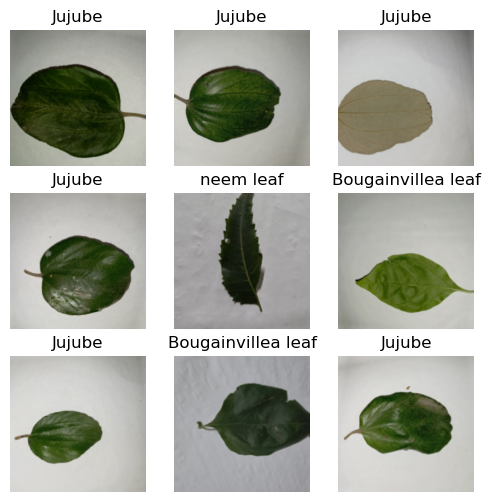

In [10]:
dls.show_batch(max_n=9, figsize=(6,6))


Next we want to do a sanity check to ensure that the DataLoaders are producing tensors of the correct shape.  This is useful as if shapes are wrong, it can prevent crashes during model training.

The code below does the following:

**dls.one_batch()**

Grabs a single batch of data from the training DataLoader (dls.train) by default.
Returns two tensors:
xb → the input images
yb → the target labels

**xb**

A tensor of shape (batch_size, channels, height, width)
For example: (32, 3, 224, 224) if bs=32 and images are resized to 224×224
Each image is converted into a PyTorch tensor, ready for the model

**yb**

A tensor of shape (batch_size,)
Each entry is the integer index of the class label corresponding to the image in xb
Example: [0, 2, 1, 0, ...] → indices into dls.vocab

**xb.shape, yb.shape**

Prints the shapes of both tensors
Quick sanity check to ensure:
Batch size matches expectations
Images have the right number of channels and resolution
Labels match the batch size

In [11]:
xb, yb = dls.one_batch()
xb.shape, yb.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

This output shows us:

xb (inputs) → torch.Size([32, 3, 224, 224])

- 32 images in this batch (batch_size=32)
- Each image has 3 channels (RGB)
- Each image is resized to 224×224 pixels

yb (labels) → torch.Size([32])

- 32 labels, one for each image in the batch
- Each label is an integer index into dls.vocab
- Example: [0, 2, 1, 0, ...] maps to classes like 'Bougainvillea leaf', 'Jujube', 'neem leaf'

## Improve Data Augmentation

Out initial data augmentation provides an initial simple pipeline and a baseline configuration that we have proved works.  However we can improve the augmentation for this project.  Because we are interested in classifying leaves, and leaves typically have differing shape, venation and texture, the model could benefit from seeing different bits of the leaf.

Previously we used resize (224) which always uses the same crop and is less robust.  This time we will refine our DataBlock and create our DataLoader and use RandomResizedCrop(224) because it produces a random crop every time, is more robust and, whilst it is slightly slower, it is better for training.

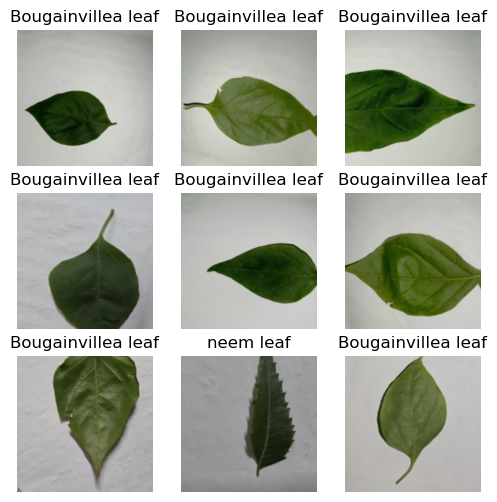

In [12]:
leaf_block = leaf_block.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

# Recreate the DataLoader
dls = leaf_block.dataloaders(path, bs=32)

# Perform a visual sanity check
dls.show_batch(max_n=9, figsize=(6,6))

## Create the model

The next step is to create the model!  These two little lines of code do alot of work...

**What vision_learner does for you**

It creates a Learner that combines:

**1. Your data**

-dls → training + validation batches
-Already resized, augmented, and labelled

**2. A pretrained model**
   
- resnet18 → a convolutional neural network trained on ImageNet
-Has already learned:

   - edges
   - textures
   - shapes

**3. A new classification head**
   
- Automatically sized for your number of leaf classes
- Randomly initialized

**4. Loss function**

- Automatically chosen based on your problem
- For multiclass classification → CrossEntropyLoss

**Metric**

- error_rate = 1 - accuracy
- Easy to interpret: lower is better

**learn.fine_tune(4)**

This is transfer learning in action. What fine_tune(4) really does
Internally, FastAI performs two training phases:

**Phase 1: Train the head**

- Freezes the pretrained backbone
- Trains only the new classification head
- 1 epoch by default

**Phase 2: Fine-tune the whole model**

- Unfreezes all layers
- Trains for 4 epochs
- Uses:
   - Discriminative learning rates
   - Gradual unfreezing
   - Smart defaults

You get all this with one line.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.172769,0.695182,0.227273,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.134540,0.026950,0.000000,01:10
1,0.076483,0.016626,0.000000,01:13
2,0.078011,0.013501,0.000000,01:12
3,0.057074,0.011698,0.000000,01:11


### So what do these results tell us?

Table 1 represents the training of the new classification head.  The pretrained ResNet backbone is frozen.  The error rate is 10.6% which means that the labels make sense, the dataset is learnable and our data pipeline works.

Table 2 represents the fine tuning of the whole model.  The entire network is being trained and the model rapidly improves.  By epoch 1, there is 0% validation error meaning the model correctly classified every validation image.  This suggests that the classes are visually distinct, the images are clean and the labels are consistent.

A point to note is that valid_loss is extremely low, which often happens when the validation set is small or augmentation is strong e.g. the training images are harder.

We canc onclude that transfer learning is doing the heavy lifting.  ResNet18 already understands edges, veins, shapes and textures, and our leaf classes map very naturally onto those features.

## Confusion Matrix

The next step is to create a confusion matrix to understand **how** the model makes mistakes, not just how many mistakes it makes.  Accuracy or error rate gives you one number, whereas a confusion matrix tells you the story behind the number.

It tell us:

**1. Which classes are confused with each other**

- Example:  Neem predicted as Jujube, or Bourgainvillea never confused with Neem.  This tells you which type of leaf looks similar in the model and which distinctions are easy for the model.  This is useful for deciding what to improve next.

**2. It validates whether the metric is meaningful.**

- We have achieved a 0.0 validation error which looks perfect.  A confusion matrix helps to answer whether the performance is perfect across all classes, or is one class dominating the dataset.

**3. It guides data cleaning and data collection**

- FastAI philosophy 'fix the data before fixing the model'.  The confusion matrix helps to identify classes that need more data, help spot labelling issues and decide where to focus augmentation.  E.g. if Neem vs Jujube confusion exists, collect clearer images.

**4.  Its a sanity check against overfitting**

- A confusion matrix helps you ask: are the classes genuinely easy, are the images too similar, is their potential data leakage.

**5. It connects directly to real-world impact.**

- A confusion matrix lets you reason about 'which mistakes are acceptable' and 'which mistakes are dangerous' e.g. misclassifying a mushroom as non poisonous is much worse than the reverse.

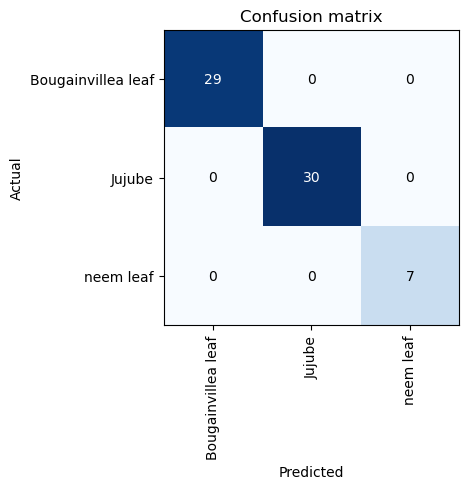

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Glossary

**train_loss**

- Measures how wrong the model is on the training data.
- It measures the average error between the model's predictions and true labels
- It is computed over all training batches in an epoch
- A lower error is better
- Because this Leaf Classifier is a multi class classification, FastAI is using Cross-Entropy loss, which was chosen automatically based on CategoryBlock and multi-label classes
- It effectively measures how confident and correct the predictions are.

**valid_loss**

- Measures how wrong the model is on the validation set e.g. how surprised is the model when it sees new images?
- It is computed on data the model has not seen during training
- It uses the same loss function as train_loss (cross-entropy)
- A lower error is better

**Useful Interpretations**

- Low valid_loss + low error_rate = model generalises well
- Low train_loss + high valid_loss = model may be overfitting
- High train_loss + high valid_loss = model underfits / learning to slow